## PDE 
The TTI wave equation for the square slowness m, thomsen parametersd $\epsilon$, $\delta$, $\theta$ and $\Phi$ (dip and asymuth)  and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 p(x,t)}{dt^2} - (1+2\epsilon)(G_{\bar{x}\bar{x}} + G_{\bar{y}\bar{y}}) p(x,t) - \sqrt{(1+2\delta)}G_{\bar{z}\bar{z}} r(x,t) =q  \\
 &m \frac{d^2 r(x,t)}{dt^2} -  \sqrt{(1+2\delta)}(G_{\bar{x}\bar{x}} + G_{\bar{y}\bar{y}}) p(x,t) - G_{\bar{z}\bar{z}} r(x,t) =q    \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}


where
\begin{cases} 
G_{\bar{x}\bar{x}} & = cos(\phi)^2 cos(\theta)^2 \frac{d^2}{dx^2} +sin(\phi)^2 cos(\theta)^2 \frac{d^2}{dy^2}+ sin(\theta)^2 \frac{d^2}{dz^2} + sin(2\phi) cos(\theta)^2 \frac{d^2}{dx dy} - sin(\phi) sin(2\theta) \frac{d^2}{dy dz} -cos(\phi) sin(2\theta) \frac{d^2}{dx dz} \\
G_{\bar{y}\bar{y}} & =  sin(\phi)^2 \frac{d^2}{dx^2} +cos(\phi)^2  \frac{d^2}{dy^2} - sin(2\phi)^2 \frac{d^2}{dx dy}\\
G_{\bar{z}\bar{z}} & = cos(\phi)^2 sin(\theta)^2 \frac{d^2}{dx^2} +sin(\phi)^2 sin(\theta)^2 \frac{d^2}{dy^2}+ cos(\theta)^2 \frac{d^2}{dz^2} + sin(2\phi) sin(\theta)^2 \frac{d^2}{dx dy} + sin(\phi) sin(2\theta) \frac{d^2}{dy dz} +cos(\phi) sin(2\theta) \frac{d^2}{dx dz} \\ 
\end{cases}
with the zero initial conditons to guaranty unicity of the solution

It correspondto a velocity model where the velocity in the z direction is different from the velocity in the xy plane

## Adjoint PDE 
The TTI wave equation for the square slowness m, thomsen parametersd $\epsilon$, $\delta$, $\theta$ and $\Phi$ (dip and asymuth)  and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 p(x,t)}{dt^2} - (G_{\bar{x}\bar{x}} + G_{\bar{y}\bar{y}})^T((1+2\epsilon) p(x,t)) - (G_{\bar{x}\bar{x}} + G_{\bar{y}\bar{y}})^T(\sqrt{(1+2\delta)} r(x,t)) = q  \\
 &m \frac{d^2 r(x,t)}{dt^2} -  G_{\bar{z}\bar{z}}^T(\sqrt{(1+2\delta)} p(x,t)) - G_{\bar{z}\bar{z}}^T r(x,t) =q    \\
 &u(.,T) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=T} = 0 
\end{cases}


where
\begin{cases} 
G_{\bar{x}\bar{x}} & = cos(\phi)^2 cos(\theta)^2 \frac{d^2}{dx^2} +sin(\phi)^2 cos(\theta)^2 \frac{d^2}{dy^2}+ sin(\theta)^2 \frac{d^2}{dz^2} + sin(2\phi) cos(\theta)^2 \frac{d^2}{dx dy} - sin(\phi) sin(2\theta) \frac{d^2}{dy dz} -cos(\phi) sin(2\theta) \frac{d^2}{dx dz} \\
G_{\bar{y}\bar{y}} & =  sin(\phi)^2 \frac{d^2}{dx^2} +cos(\phi)^2  \frac{d^2}{dy^2} - sin(2\phi)^2 \frac{d^2}{dx dy}\\
G_{\bar{z}\bar{z}} & = cos(\phi)^2 sin(\theta)^2 \frac{d^2}{dx^2} +sin(\phi)^2 sin(\theta)^2 \frac{d^2}{dy^2}+ cos(\theta)^2 \frac{d^2}{dz^2} + sin(2\phi) sin(\theta)^2 \frac{d^2}{dx dy} + sin(\phi) sin(2\theta) \frac{d^2}{dy dz} +cos(\phi) sin(2\theta) \frac{d^2}{dx dz} \\ 
\end{cases}
with the zero initial conditons to guaranty unicity of the solution

It correspondto a velocity model where the velocity in the z direction is different from the velocity in the xy plane

In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

In [2]:
p=Function('p')
r=Function('r')

s,h,x,y,z = symbols('s h x y z')
m=M(x,y,z)
q=Q(x,y,z,t)
d=D(x,y,z,t)
e=E(x,y,z)

A=epsilon(x,y,z)  # (1 + 2epsilon) but make the symbolic simpler
B=delta(x,y,z) # sqrt(1 + 2epsilon) but make the symbolic simpler
Th=theta(x,y,z)
Ph=phi(x,y,z)


In [3]:
dttp=as_finite_diff(p(x,y,z,t).diff(t,t), [t-s,t, t+s])
dttr=as_finite_diff(r(x,y,z,t).diff(t,t), [t-s,t, t+s])
dtp=as_finite_diff(p(x,y,z,t).diff(t), [t-s,t])
dtr=as_finite_diff(r(x,y,z,t).diff(t), [t-s,t])
# Spacial finite differences can easily be extended to higher order by increasing the list of sampling point in the next expression. 
# Be sure to keep this stencil symmetric and everything else in the notebook will follow.
dxxp=as_finite_diff(p(x,y,z,t).diff(x,x), [x-h, x, x+h]) 
dyyp=as_finite_diff(p(x,y,z,t).diff(y,y), [y-h, y, y+h]) 
dzzp=as_finite_diff(p(x,y,z,t).diff(z,z), [z-h, z, z+h])
dxxr=as_finite_diff(r(x,y,z,t).diff(x,x), [x-h, x, x+h]) 
dyyr=as_finite_diff(r(x,y,z,t).diff(y,y), [y-h, y, y+h]) 
dzzr=as_finite_diff(r(x,y,z,t).diff(z,z), [z-h, z, z+h])


# My 4th order stencil for cross derivatives
dxzp = .5/(h**2)*(-2*p(x,y,z,t) + p(x,y,z+h,t) + p(x,y,z-h,t) - p(x+h,y,z-h,t) + p(x-h,y,z,t) - p(x-h,y,z+h,t) + p(x+h,y,z,t))
dxzr = .5/(h**2)*(-2*r(x,y,z,t) + r(x,y,z+h,t) + r(x,y,z-h,t) - r(x+h,y,z-h,t) + r(x-h,y,z,t) - r(x-h,y,z+h,t) + r(x+h,y,z,t))

dxyp = .5/(h**2)*(-2*p(x,y,z,t) + p(x,y+h,z,t) + p(x,y-h,z,t) - p(x+h,y-h,z,t) + p(x-h,y,z,t) - p(x-h,y+h,z,t) + p(x+h,y,z,t))
dxyr = .5/(h**2)*(-2*r(x,y,z,t) + r(x,y+h,z,t) + r(x,y-h,z,t) - r(x+h,y-h,z,t) + r(x-h,y,z,t) - r(x-h,y+h,z,t) + r(x+h,y,z,t))

dyzp = .5/(h**2)*(-2*p(x,y,z,t) + p(x,y,z+h,t) + p(x,y,z-h,t) - p(x,y+h,z-h,t) + p(x,y-h,z,t) - p(x,y-h,z+h,t) + p(x,y+h,z,t))
dyzr = .5/(h**2)*(-2*r(x,y,z,t) + r(x,y,z+h,t) + r(x,y,z-h,t) - r(x,y+h,z-h,t) + r(x,y-h,z,t) - r(x,y-h,z+h,t) + r(x,y+h,z,t))

In [4]:
Gxxp = c**2 * a**2 * dxxp + d**2 * a**2 * dyyp + b**2 * dzzp + 2 * d * c * a**2 * dxyp - d * 2 * b * a * dyzp - c * 2 * b * a * dxzp
Gyyp = b**2 * dxxp + c**2 * dyyp - (2 * d * c)**2 * dxyp
Gzzr = c**2 * b**2 * dxxr + d**2 * b**2 * dyyr + a**2 * dzzr + 2 * d * c * b**2 * dxyr + d * 2 * b * a * dyzr + c * 2 * b * a * dxzr

In [5]:
def Bhaskarasin(angle):
    return 16 * angle * (3.14 - abs(angle))/(49.34 - 4 * abs(angle) * (3.14 - abs(angle)))

def Bhaskaracos(angle):
    return Bhaskarasin(angle + 1.57)

a = Bhaskaracos(Th)
b = Bhaskarasin(Th)
c = Bhaskaracos(Ph)
d = Bhaskaracos(Ph)

In [6]:
stencilp = s**2/m*( (2 - e/s) * p(x, y, z, t) - (m/s**2 + e/s)*p(x, y, z, t-s) + A * (Gxxp + Gyyp) + B * Gzzr)

In [7]:
stencilp = factor(simplify(expand(stencilp)))

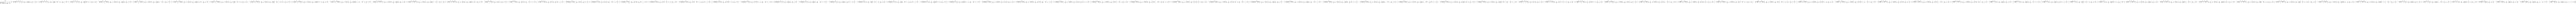

In [8]:
stencilp

In [9]:
stencilr = 2 * s**2 / (2 * m + s * e) * (2 * m / s**2 * r(x, y, z, t) + (s * e - 2 * m) / (2 * s**2) * r(x, y, z, t-s) + A * (Gxxp + Gyyp) + B * Gzzr)

In [10]:
stencilr=factor(simplify(expand(stencilr)))

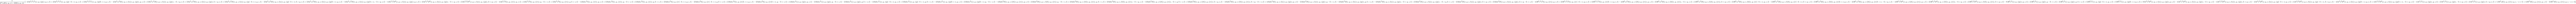

In [11]:
stencilr

# Adjoint

In [12]:
def fd_coeff_2(order):
    if order==16:
        coeffs = [-3.054844, 1.777778, -0.311111, 0.075421, -0.017677, 0.003481, -0.000518, 0.000051, -0.000002]
        
    if order==14:
        coeffs = [-3.023594, 1.750000, -0.291667, 0.064815, -0.013258, 0.002121, -0.000227, 0.000012]
        
    if order==12:
        coeffs = [-2.982778, 1.714286, -0.267857, 0.052910, -0.008929, 0.001039, -0.000060]
        
    if order==10:
        coeffs = [-2.927222, 1.666667, -0.238095, 0.039683, -0.004960, 0.000317]
        
    if order==8:
        coeffs = [-2.847222, 1.600000, -0.200000, 0.025397, -0.001786]
    
    if order==6:
        coeffs = [-2.722222, 1.500000, -0.150000, 0.01111]
    
    if order==4:
        coeffs = [-2.500000, 1.333333, -0.08333]
    
    if order==2:
        coeffs = [-2, 1]

    return coeffs

In [13]:
p=Function('p')
r=Function('r')
a=Function('a')
b=Function('b')
c=Function('c')
d=Function('d')
epsilon=Function('epsilon')
delta=Function('delta')

# Define second derivatives function that works for a product of any functions as if it was a single function

In [14]:
def dxxa(order, h, p, *args):
    coeffs = fd_coeff_2(order)
    res = coeffs[0] * p(x, y, z, t)
    for j in range(0,len(args)):
        res = res * args[j](x, y, z)

    for i in range(1,int(order/2)+1):
        aux1 = p(x + i * h, y, z, t)
        aux2 = p(x - i * h, y, z, t)
        for j in range(0,len(args)):
            aux1 = aux1 * args[j](x + i * h, y, z)
            aux2 = aux2 * args[j](x - i * h, y, z)
        res = res + coeffs[i]*( aux1 + aux2)
    return (1/h**2)*res

def dyya(order, h, p, *args):
    coeffs = fd_coeff_2(order)
    res = coeffs[0] * p(x, y, z, t)
    for j in range(0,len(args)):
        res = res * args[j](x, y, z)

    for i in range(1,int(order/2)+1):
        aux1 = p(x, y + i * h, z, t)
        aux2 = p(x, y - i * h, z, t)
        for j in range(0,len(args)):
            aux1 = aux1 * args[j](x, y + i * h, z)
            aux2 = aux2 * args[j](x, y - i * h, z)
        res = res + coeffs[i]*( aux1 + aux2)
    return (1/h**2)*res

def dzza(order, h, p, *args):
    coeffs = fd_coeff_2(order)
    res = coeffs[0] * p(x, y, z, t)
    for j in range(0,len(args)):
        res = res * args[j](x, y, z)

    for i in range(1,int(order/2)+1):
        aux1 = p(x, y, z + i * h, t)
        aux2 = p(x, y, z - i * h, t)
        for j in range(0,len(args)):
            aux1 = aux1 * args[j](x, y, z + i * h)
            aux2 = aux2 * args[j](x, y, z - i * h)
        res = res + coeffs[i]*( aux1 + aux2)
    return (1/h**2)*res


# Define cross derivatives function that works for a product of any functions as if it was a single function

In [22]:
def dxya(h, p, *args):
    res = -2 * p(x, y, z, t)
    for j in range(0,len(args)):
        res = res * args[j](x, y, z)
    # x direction
    aux1 = p(x + h, y, z, t)
    aux2 = p(x - h, y, z, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x + h, y, z)
        aux2 = aux2 * args[j](x - h, y, z)
    res = res + aux1 + aux2
    # y direction
    aux1 = p(x, y + h, z, t)
    aux2 = p(x, y - h, z, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x, y + h, z)
        aux2 = aux2 * args[j](x, y - h, z)
    # Diagonal elements
    aux1 = p(x - h, y + h, z, t)
    aux2 = p(x + h, y - h, z, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x - h, y + h, z)
        aux2 = aux2 * args[j](x + h, y - h, z)
    res = res - aux1 + aux2
    return .5/(h**2)*res

def dxza(h, p, *args):
    res = -2 * p(x, y, z, t)
    for j in range(0,len(args)):
        res = res * args[j](x, y, z)
        # x direction
    aux1 = p(x + h, y, z, t)
    aux2 = p(x - h, y, z, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x + h, y, z)
        aux2 = aux2 * args[j](x - h, y, z)
    res = res + aux1 + aux2
    # z direction
    aux1 = p(x, y, z + h, t)
    aux2 = p(x, y, z - h, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x, y, z + h)
        aux2 = aux2 * args[j](x, y, z - h)
    # Diagonal elements
    aux1 = p(x - i * h, y, z + h, t)
    aux2 = p(x + i * h, y, z - h, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x - h, y, z + h)
        aux2 = aux2 * args[j](x + h, y, z - h)
    res = res - aux1 + aux2
    return .5/(h**2)*res

def dyza(h, p, *args):
    res = -2 * p(x, y, z, t)
    for j in range(0,len(args)):
        res = res * args[j](x, y, z)
    # z direction
    aux1 = p(x, y, z + h, t)
    aux2 = p(x, y, z - h, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x, y, z + h)
        aux2 = aux2 * args[j](x, y, z - h)
    res = res + aux1 + aux2
    # y direction
    aux1 = p(x, y + h, z, t)
    aux2 = p(x, y - h, z, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x, y + h, z)
        aux2 = aux2 * args[j](x, y - h, z)
    # Diagonal elements
    aux1 = p(x, y + h, z - h, t)
    aux2 = p(x, y - h, z + h, t)
    for j in range(0,len(args)):
        aux1 = aux1 * args[j](x, y + h, z - h)
        aux2 = aux2 * args[j](x, y - h, z + h)
    res = res - aux1 + aux2
    return .5/(h**2)*res

# Stencils

In [23]:
Gxxpa = dxxa(2,h,p,epsilon,a,a,c,c) + dyya(2,h,p,epsilon,d,d,a,a) + dzza(2,h,p,epsilon,b,b) + 2*dxya(h,p,epsilon,a,a,c,d) - 2 * dyza(h,p,epsilon,a,b,d) - 2 * dxza(h,p,epsilon,a,b,c)
Gyypa = dxxa(2,h,p,epsilon,b,b) + dyya(2,h,p,epsilon,c,c) - 4 * dxya(h,p,epsilon,c,c,d,d)

Gxxra = dxxa(2,h,r,delta,a,a,c,c) + dyya(2,h,r,delta,d,d,a,a) + dzza(2,h,r,delta,b,b) + 2*dxya(h,r,delta,a,a,c,d) - 2 * dyza(h,r,delta,a,b,d) - 2 * dxza(h,r,delta,a,b,c)
Gyyra = dxxa(2,h,r,delta,b,b) + dyya(2,h,r,delta,c,c) - 4 * dxya(h,r,delta,c,c,d,d)



Gzzpa = dxxa(2,h,p,delta,b,b,c,c) + dyya(2,h,p,delta,d,d,b,b) + dzza(2,h,p,delta,a,a) + 2*dxya(h,p,delta,b,b,c,d) + 2 * dyza(h,p,delta,a,b,d) + 2 * dxza(h,p,delta,a,b,c)
Gzzra = dxxa(2,h,r,b,b,c,c) + dyya(2,h,r,d,d,b,b) + dzza(2,h,r,a,a) + 2*dxya(h,r,b,b,c,d) + 2 * dyza(h,r,a,b,d) + 2 * dxza(h,r,a,b,c)

In [24]:
wavepa = m * dttp - ( Gxxpa + Gyypa + Gxxra + Gyyra)
wavera = m * dttp - ( Gzzpa + Gzzra)

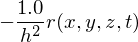

In [32]:
dxya(h,r)

In [25]:
stencilpa =  s**2/m*( (2 - e/s) * p(x, y, z, t) - (m/s**2 + e/s)*p(x, y, z, t+s) +  Gxxpa + Gyypa + Gxxra + Gyyra)

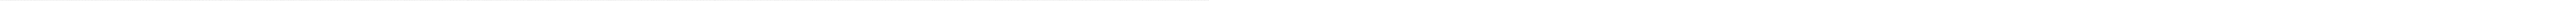

In [26]:
stencilpa

In [20]:
stencilra = s**2/m*( (2 - e/s) * r(x, y, z, t) - (m/s**2 + e/s)*r(x, y, z, t+s) +  Gzzpa + Gzzra)

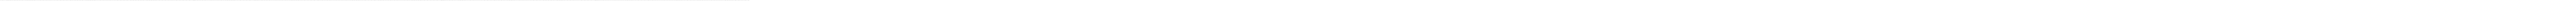

In [21]:
stencilra